# Multi-Objective Optimization

**S. Doncieux, Sorbonne University, 2022, [stephane.doncieux@sorbonne-universite.fr](mailto:stephane.doncieux@sorbonne-universite.fr)**

_UE Robotique et Apprentissage, Master ANDROIDE_

## Converging to an approximation of the Pareto front with EA

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
import numpy as np
import importlib
import random

random.seed()

from deap import base, creator, benchmarks

from deap import tools


## Preparing the tools

In [2]:
from operator import mul

def weighted_sum(fit, w):
    return sum(map(mul, fit, w))

def tchebycheff(fit,w, ref_point=None):
    if (ref_point is None):
        print("Error, the reference point needs to be defined")
        raise ValueError
    v=[abs(fit[i]-ref_point[i]) for i in range(len(fit))]
    w=np.abs(w)
    return -max(map(mul, v, w))

def EA_tournament(NGEN=40, POPSIZE=10, evaluate=benchmarks.zdt1, evaluate_args=None, w=(-1.0,-1.0), scalarizing=weighted_sum, scalarizing_args=None):
    # Simple tournament based mono-objective EA.
    
    ## We create the types we need ##

    MIN_V=0.0
    MAX_V=1.0

    # Fitness that is minimized (-1 weight)
    if (hasattr(creator, "Fitness")):
        # Deleting any previous definition (to avoid warning message)
        del creator.Fitness
    creator.create("Fitness", base.Fitness, weights=(1.0,)) # leave it with 1, the weights are set elsewhere

    # Individual that uses this fitness
    if (hasattr(creator, "Individual")):
        # Deleting any previous definition (to avoid warning message)
        del creator.Individual
    creator.create("Individual", list, fitness=creator.Fitness)

    ## Tool initialization ##
    IND_SIZE = 30

    # toolbox is a container, each registered function can be called later on. Example:
    # toolbox.register("my_function", my_great_function, default_param=42)
    # toobox.my_function(...) calls my_great_function(...)
    # some parameters with default values can be defined when registering the function, 
    # they are then transmitted to it when it is called 
    # (in the example, the param default_param is transmitted to the function with the value 42)
    toolbox = base.Toolbox()

    # parameters are initialized between 0 and 1
    toolbox.register("attribute", random.uniform, MIN_V, MAX_V)

    # individuals are made with IND_SIZE parameters
    toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attribute, n=IND_SIZE)

    # the population is a list of individuals
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)


    # 2 points crossover
    toolbox.register("mate", tools.cxSimulatedBinaryBounded, eta=15, low=MIN_V, up=MAX_V)

    # gaussian mutation
    toolbox.register("mutate", tools.mutPolynomialBounded, eta=15, low=MIN_V, up=MAX_V, indpb=0.1)

    # Tournament selection: select the best out of X randomly selected individuals (with X=3)
    toolbox.register("select", tools.selTournament, tournsize=3)

    # Evaluation function to use
    if (evaluate_args is None):
        toolbox.register("evaluate", evaluate)
    else:
        toolbox.register("evaluate", evaluate, **evaluate_args)

    # Les statistiques permettant de récupérer les résultats
    stats = tools.Statistics(key=lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)
    stats_all = tools.Statistics(key=lambda ind: ind.all_objs)
    stats_all.register("all", lambda x:x)

    
    # La structure qui permet de stocker les statistiques
    logbook = tools.Logbook()


    # La structure permettant de récupérer le meilleur individu
    hof = tools.HallOfFame(1)
    
    # Initialising the population
    pop = toolbox.population(n=POPSIZE)
    CXPB, MUTPB = 0.5, 0.2

    # Evaluate the entire population
    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.all_objs = fit
        if (scalarizing_args is None):
            ind.fitness.values = scalarizing(fit, w), 
        else:
            ind.fitness.values = scalarizing(fit, w, **scalarizing_args), 
            
    for g in range(NGEN):
        # Select the next generation individuals
        offspring = toolbox.select(pop, len(pop))
        # Clone the selected individuals
        offspring = list(map(toolbox.clone, offspring))

        # Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.all_objs = fit
            if (scalarizing_args is None):
                ind.fitness.values = scalarizing(fit, w), 
            else:
                ind.fitness.values = scalarizing(fit, w, **scalarizing_args), 

        # The population is entirely replaced by the offspring
        pop[:] = offspring
        
        hof.update(pop)
        stat = stats.compile(pop)
        stat_all = stats_all.compile(pop)
        logbook.record(gen=g,**stat, **stat_all)

    return pop, hof, logbook

In [299]:
pop_v, hof_v, logbook_v=EA_tournament(20, 10, benchmarks.zdt1)

In [300]:
p=logbook_v.select("all")
p[0][0]

(0.48140982923678977, 3.4676072343306523)

In [135]:

def MOGA(NGEN=40, POPSIZE=10, evaluate=benchmarks.zdt1, evaluate_args=None, w=(-1.0,-1.0)):
    # EA algorithm inspired from MOGA's ideas as described in 
    # Fonseca, C. M., & Fleming, P. J. (1993, July). Genetic Algorithms for Multiobjective Optimization: 
    # Formulation Discussion and Generalization. In ICGA (Vol. 93, No. July, pp. 416-423).
    
    ## We create the types we need ##

    MIN_V=0.0
    MAX_V=1.0

    
    if (hasattr(creator, "Fitness")):
        # Deleting any previous definition (to avoid warning message)
        del creator.Fitness
    creator.create("Fitness", base.Fitness, weights=w) 

    if (hasattr(creator, "FitnessRank")):
        # Deleting any previous definition (to avoid warning message)
        del creator.FitnessRank
    creator.create("FitnessRank", base.Fitness, weights=[-1.0]) 

    # Individual that uses this fitness
    if (hasattr(creator, "Individual")):
        # Deleting any previous definition (to avoid warning message)
        del creator.Individual
    creator.create("Individual", list, fitness=creator.Fitness)

    ## Tool initialization ##
    IND_SIZE = 30

    # toolbox is a container, each registered function can be called later on. Example:
    # toolbox.register("my_function", my_great_function, default_param=42)
    # toobox.my_function(...) calls my_great_function(...)
    # some parameters with default values can be defined when registering the function, 
    # they are then transmitted to it when it is called 
    # (in the example, the param default_param is transmitted to the function with the value 42)
    toolbox = base.Toolbox()

    # parameters are initialized between 0 and 1
    toolbox.register("attribute", random.uniform, MIN_V, MAX_V)

    # individuals are made with IND_SIZE parameters
    toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attribute, n=IND_SIZE)

    # the population is a list of individuals
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)


    # 2 points crossover
    toolbox.register("mate", tools.cxSimulatedBinaryBounded, eta=15, low=MIN_V, up=MAX_V)

    # gaussian mutation
    toolbox.register("mutate", tools.mutPolynomialBounded, eta=15, low=MIN_V, up=MAX_V, indpb=0.1)

    # Roulette wheel
    #toolbox.register("select", tools.selRoulette, fit_attr='fit_rank')
    toolbox.register("select", tools.selTournament, tournsize=3, fit_attr='fit_rank')
    #toolbox.register("select", tools.selBest, fit_attr='fit_rank')
    
    # Evaluation function to use
    if (evaluate_args is None):
        toolbox.register("evaluate", evaluate)
    else:
        toolbox.register("evaluate", evaluate, **evaluate_args)

    # Les statistiques permettant de récupérer les résultats
    stats = tools.Statistics(key=lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)
    stats.register("all", lambda x:x)

    # La structure qui permet de stocker les statistiques
    logbook = tools.Logbook()


    # La structure permettant de récupérer le meilleur individu
    hof = tools.HallOfFame(1)
    
    # Initialising the population
    pop = toolbox.population(n=POPSIZE)
    CXPB, MUTPB = 0.5, 0.2

    # Evaluate the entire population
    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit 
    
    # Computing the rank
    for i1 in range(len(pop)):
        pop[i1].rank=1
        
    sum_rank=0
    ranks=[]
    for i1 in range(len(pop)):
        for i2 in range(i1+1, len(pop)):
            if tools.emo.isDominated(pop[i1].fitness.wvalues, pop[i2].fitness.wvalues):
                pop[i1].rank+=1
                #print("+",end="")
            elif tools.emo.isDominated(pop[i2].fitness.wvalues, pop[i1].fitness.wvalues):
                pop[i2].rank+=1
                #print("-",end="")
            #print("(%d)"%(pop[i1].rank), end="")
        #print("")
        ranks.append(pop[i1].rank)
        sum_rank+=pop[i1].rank
    
    tools.emo.assignCrowdingDist(pop)
    
    #max_rank=max(ranks)
    #print(" == pop update ==")
    for i1 in range(len(pop)):
        pop[i1].fit_rank=creator.FitnessRank([pop[i1].rank+1/(pop[i1].fitness.crowding_dist+1.001)])
        #pop[i1].sel_rate=creator.FitnessRank([(max_rank-pop[i1].rank+1)/max_rank])
        #print("pop[%d]: "%(i1)+" fit="+str(pop[i1].fitness.values)+" rank=%d sel_rate=%f"%(pop[i1].rank, pop[i1].sel_rate.values[0]))
    
    for g in range(NGEN):
        # Select the next generation individuals
        #offspring = toolbox.select(pop, POPSIZE)
        # Clone the selected individuals
        #offspring = toolbox.select(pop, len(pop))
        offspring = list(map(toolbox.clone, pop))
        
        ## uncomment to plot the current (1) population, (2) offspring and (3) selected individuals 
        ## plotting (1) the current population
        #xp=[]
        #yp=[]
        #for o in offspring:
        #    xxp, yyp = o.fitness.values
        #    xp.append(xxp)
        #    yp.append(yyp)
        #plt.plot(xp,yp, "+", label="Parents")
        
        #print(" == offspring (after parent selection) ==")
        #for i1 in range(len(offspring)):
        #    print("offspring[%d]: "%(i1)+" fit="+str(offspring[i1].fitness.values)+" rank=%d sel_rate=%f"%(offspring[i1].rank, offspring[i1].sel_rate.values[0]))
        
        #offspring = list(map(toolbox.clone, offspring))

        # Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values
        
        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit 
    
        ## plotting (2) offspring
        #xp=[]
        #yp=[]
        #for o in offspring:
        #    xxp, yyp = o.fitness.values
        #    xp.append(xxp)
        #    yp.append(yyp)
        #plt.plot(xp,yp,"o", label="Offspring")
    
    
    
        pop[:]=offspring + pop
    
        # Computing the rank
        for i1 in range(len(pop)):
            pop[i1].rank=1
            
        ranks=[]
        sum_rank=0
        for i1 in range(len(pop)):
            for i2 in range(i1+1, len(pop)):
                if tools.emo.isDominated(pop[i1].fitness.wvalues, pop[i2].fitness.wvalues):
                    pop[i1].rank+=1
                    #print("+",end="")
                elif tools.emo.isDominated(pop[i2].fitness.wvalues, pop[i1].fitness.wvalues):
                    pop[i2].rank+=1
                    #print("-",end="")
            #print("")
            ranks.append(pop[i1].rank)
            sum_rank+=pop[i1].rank
        max_rank=max(ranks)
        
        tools.emo.assignCrowdingDist(pop)

        #print(" == pop update ==")
        for i1 in range(len(pop)):
            pop[i1].fit_rank=creator.FitnessRank([pop[i1].rank+1/(pop[i1].fitness.crowding_dist+1.001)])
            #pop[i1].sel_rate=creator.FitnessRank([(max_rank-pop[i1].rank+1)/max_rank])
            #print("pop[%d]: "%(i1)+" fit="+str(pop[i1].fitness.values)+" rank=%d sel_rate=%f"%(pop[i1].rank, pop[i1].sel_rate.values[0]))
        
        pop[:] = toolbox.select(pop, POPSIZE)
        
        ## plotting (3) selected individuals
        #xp=[]
        #yp=[]
        #xr=[]
        #yr=[]
        #for o in pop:
        #    xxp, yyp = o.fitness.values
        #    xp.append(xxp)
        #    yp.append(yyp)
        #    if (o.rank==1):
        #        xr.append(xxp)
        #        yr.append(yyp)
                
        #plt.plot(xp,yp, ".", label="Selected")
        #plt.plot(xr,yr, "o", label="Rank=1")
        #plt.legend()
        #plt.show()
        
        hof.update(pop)
        stat = stats.compile(pop)
        logbook.record(gen=g,**stat)

    return pop, hof, logbook

In [136]:
from os.path import exists

def get_fitness_values(pop, evaluate, evaluate_args=None):
    x=[]
    y=[]
    for i,ind in enumerate(pop):
        if (evaluate_args is None):
            f=evaluate(ind)
        else:
            f=evaluate(ind, **evaluate_args)
        x.append(f[0])
        y.append(f[1])
    return x, y




In [137]:
nbgen=200

evaluate=benchmarks.zdt1
if (exists(evaluate.__name__+".npy")):
    print("Found a reference pareto front")
    pf_ref=np.load(evaluate.__name__+".npy")
else:
    print("No reference pareto front found")
    pf_ref=None
if (pf_ref is not None):
    x_ref,y_ref = get_fitness_values(pf_ref, evaluate)
else:
    x_ref=[]
    y_ref=[]
    
pop_ea, hof_ea, logbook_ea=EA_tournament(nbgen, 164, evaluate)
pop_mo, hof_mo, logbook_mo=MOGA(nbgen, 164, evaluate)


Found a reference pareto front


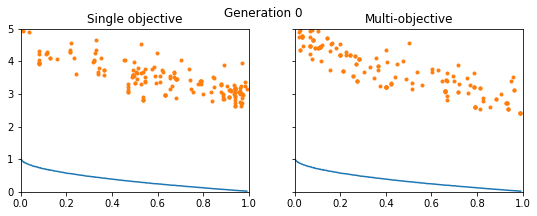

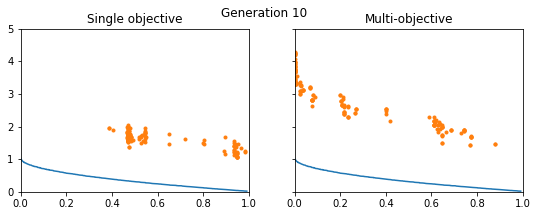

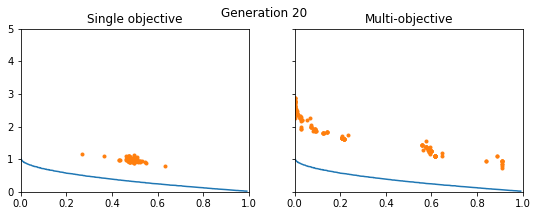

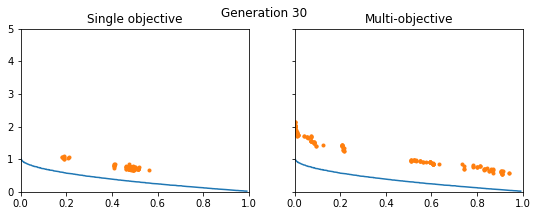

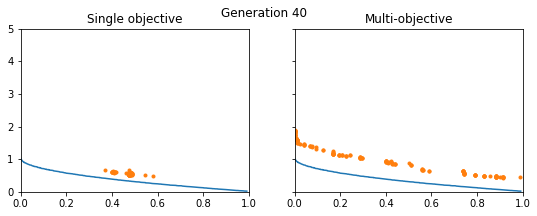

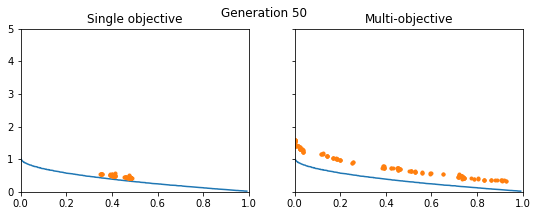

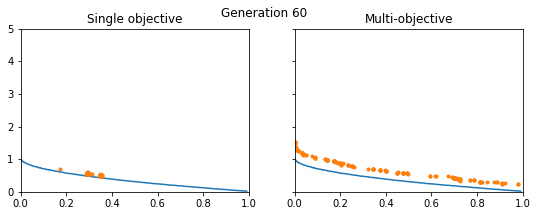

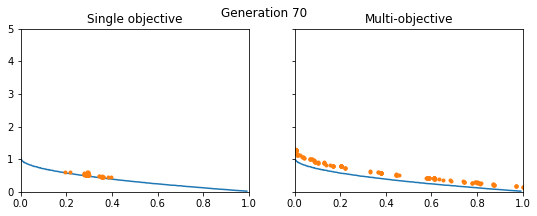

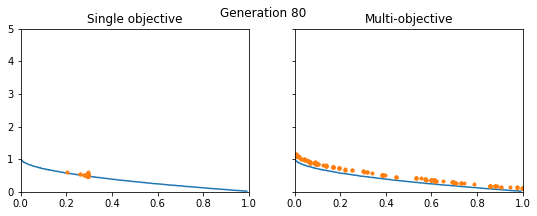

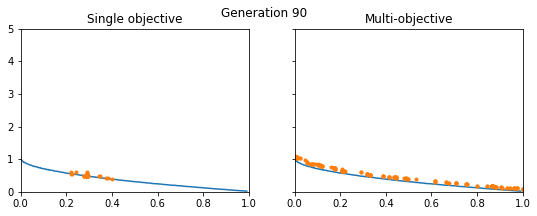

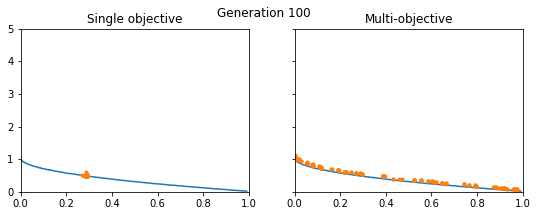

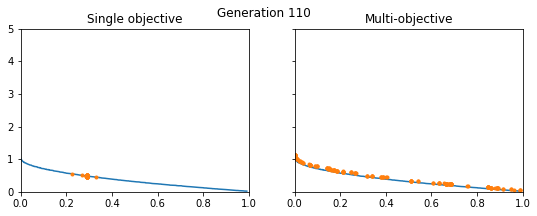

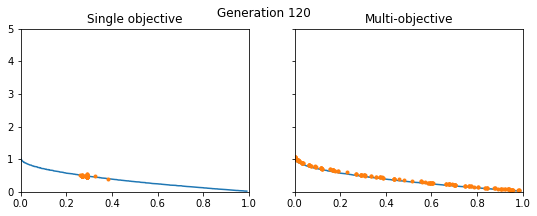

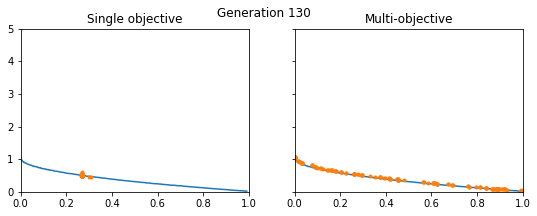

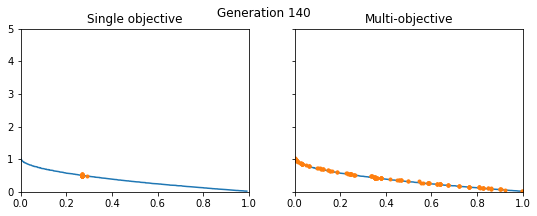

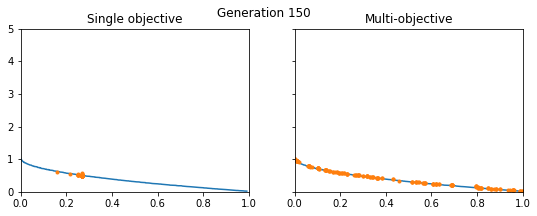

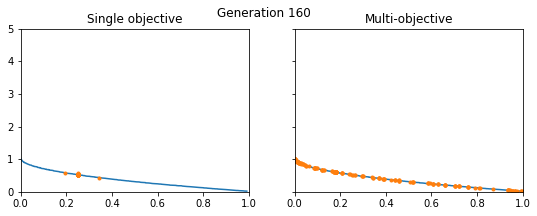

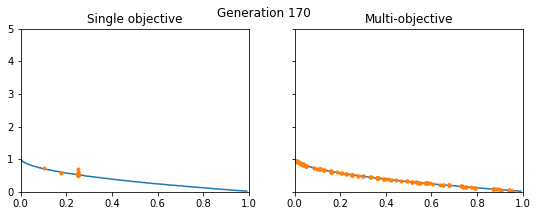

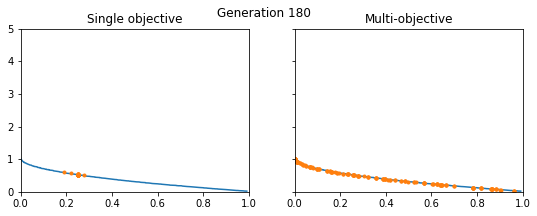

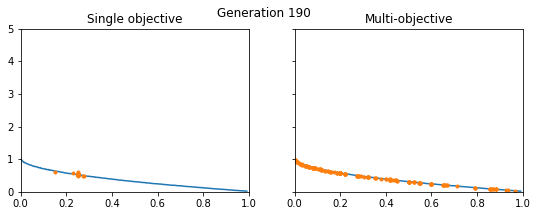

In [138]:
pop_ea=logbook_ea.select("all")
pop_mo=logbook_mo.select("all")

nbgen=200
for g in range(nbgen):
    if(g%10==0):
        fig, axs = plt.subplots(1, 2, figsize=(9, 3), sharey=True, sharex=True)
        x_ea=[i[0] for i in pop_ea[g]]
        y_ea=[i[1] for i in pop_ea[g]]

        x_mo=[i[0] for i in pop_mo[g]]
        y_mo=[i[1] for i in pop_mo[g]]

        axs[0].plot(x_ref,y_ref, label="True pareto front (approx.)") 
        axs[1].plot(x_ref,y_ref, label="True pareto front (approx.)") 
        
        axs[0].plot(x_ea, y_ea,".")
        axs[0].set_title("Single objective")
        
        axs[1].plot(x_mo, y_mo, ".")
        axs[1].set_title("Multi-objective")

        axs[0].set_xbound(lower=0, upper=1)
        axs[0].set_ybound(lower=0, upper=5)

        fig.suptitle("Generation %d"%(g))
        fig.savefig("zdt1_MOGA_gen%d.pdf"%(g))


Found a reference pareto front


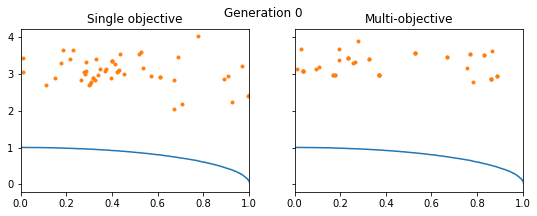

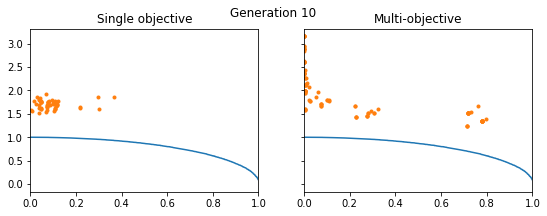

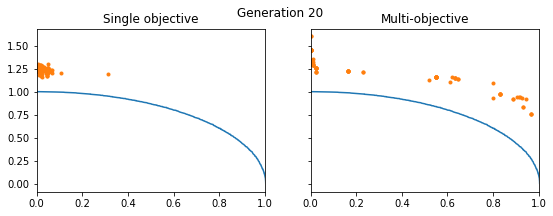

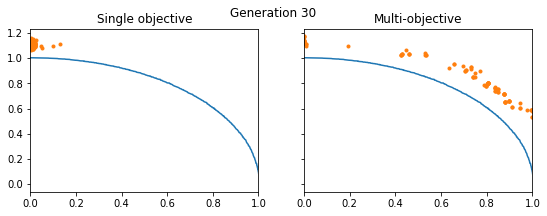

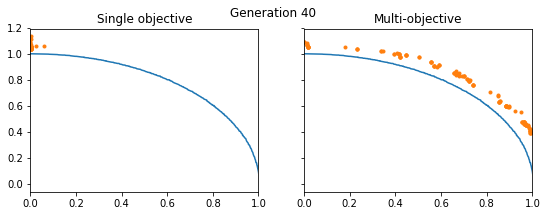

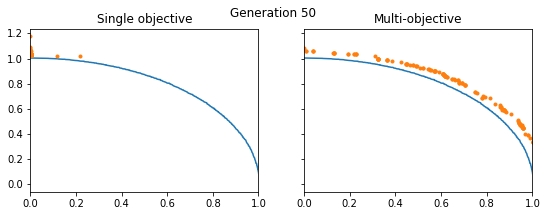

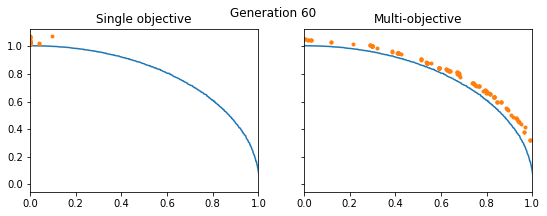

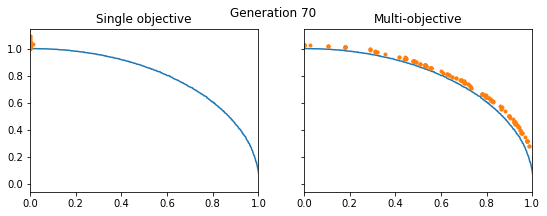

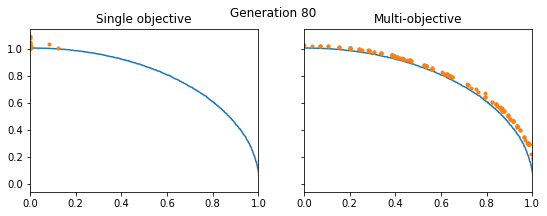

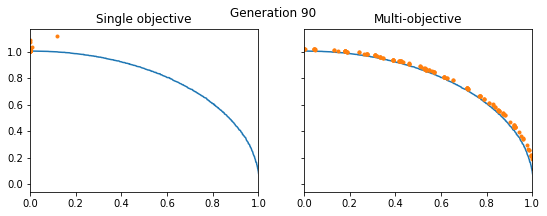

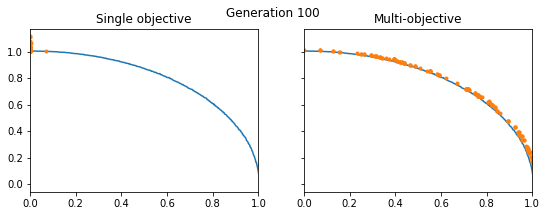

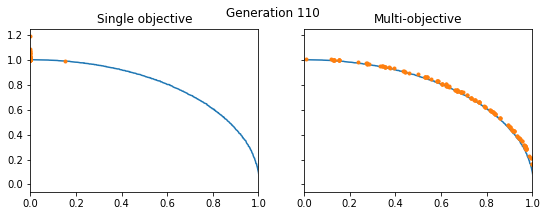

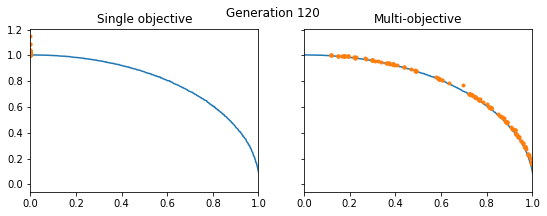

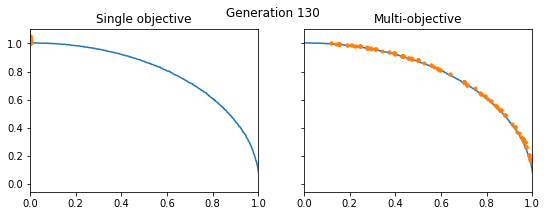

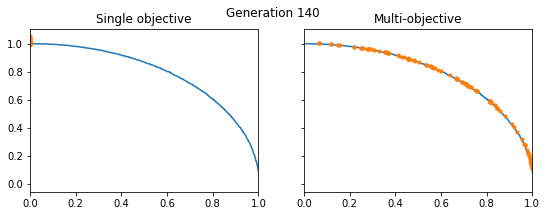

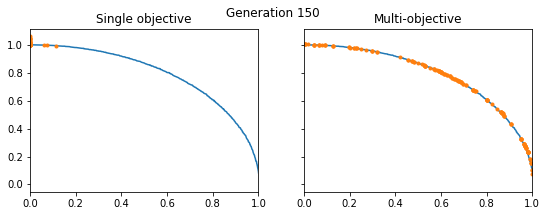

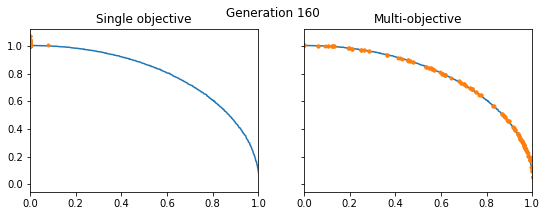

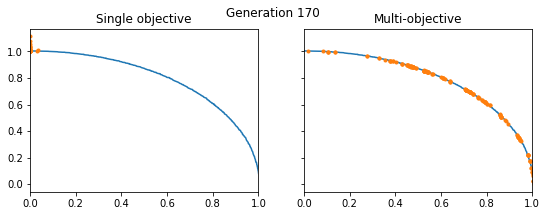

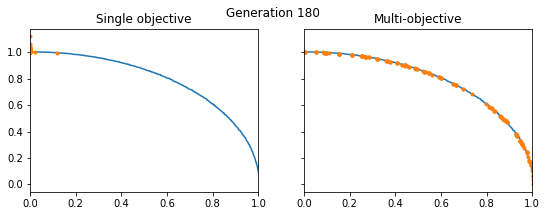

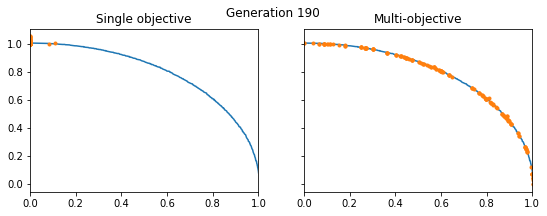

In [130]:
nbgen=200

evaluate=benchmarks.dtlz2
evaluate_args={"obj": 2}
if (exists(evaluate.__name__+".npy")):
    print("Found a reference pareto front")
    pf_ref=np.load(evaluate.__name__+".npy")
else:
    print("No reference pareto front found")
    pf_ref=None
if (pf_ref is not None):
    x_ref,y_ref = get_fitness_values(pf_ref, evaluate, evaluate_args)
else:
    x_ref=[]
    y_ref=[]

pop_ea, hof_ea, logbook_ea=EA_tournament(nbgen, 164, evaluate, evaluate_args=evaluate_args)
pop_mo, hof_mo, logbook_mo=MOGA(nbgen, 164, evaluate, evaluate_args=evaluate_args)

pop_ea=logbook_ea.select("all")
pop_mo=logbook_mo.select("all")


nbgen=200
for g in range(nbgen):
    if(g%10==0):
        fig, axs = plt.subplots(1, 2, figsize=(9, 3), sharey=True, sharex=True)
        x_ea=[i[0] for i in pop_ea[g]]
        y_ea=[i[1] for i in pop_ea[g]]

        x_mo=[i[0] for i in pop_mo[g]]
        y_mo=[i[1] for i in pop_mo[g]]

        axs[0].plot(x_ref,y_ref, label="True pareto front (approx.)") 
        axs[1].plot(x_ref,y_ref, label="True pareto front (approx.)") 
        
        axs[0].plot(x_ea, y_ea,".")
        axs[0].set_title("Single objective")
        
        axs[1].plot(x_mo, y_mo, ".")
        axs[1].set_title("Multi-objective")

        axs[0].set_xbound(lower=0, upper=1)

        fig.suptitle("Generation %d"%(g))
        fig.savefig("dtlz2_MOGA_gen%d.pdf"%(g))
